# Extending concept of using ViT encoder from SeTR to 3D segmentation tasks
## Summary: This notebook is a proof of concept that extends the use of ViT encoder in a 2D segmentation model like that presented in SeTR to 3D segementation by using a 3D ViT as encoder and 3D CNN-based decoder. I provided simple examples of the model trained to segmenet 3D cubes with a spehere inside.

##relevant papers:

*  SETR: https://arxiv.org/pdf/2012.15840
*  UNETR: https://arxiv.org/pdf/2103.10504

##source code referenced:
* UNETR implementation: https://github.com/tamasino52/UNETR/blob/main/unetr.py#L231
* ViT-Pytorch implementation: https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/simple_vit_3d.py#L114
###Name: Hanson Li



Install vit-pytorch. We will be using their 3D ViT as the encoder

In [ ]:
! pip install vit-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 9.1 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from vit_pytorch.simple_vit_3d import SimpleViT
from vit_pytorch.simple_vit_3d import posemb_sincos_3d, Transformer, pair, Attention, FeedForward
from einops import rearrange
from einops.layers.torch import Rearrange
from PIL import Image as PILImage # Import PIL.Image with an alias
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
import glob
import time
from IPython.display import Image, display, HTML # Keep IPython.display.Image for displaying
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Decoder implementation is taken from the UNETR paper

In [ ]:
#source code for these conv block implemenations is from this UNETR implementation: https://github.com/tamasino52/UNETR/blob/main/unetr.py#L231
class SingleDeconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super().__init__()
        self.block = nn.ConvTranspose3d(in_planes, out_planes, kernel_size=2, stride=2, padding=0, output_padding=0)

    def forward(self, x):
        return self.block(x)


class SingleConv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super().__init__()
        self.block = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=1,
                               padding=((kernel_size - 1) // 2))

    def forward(self, x):
        return self.block(x)


class Conv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleConv3DBlock(in_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)


class Deconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleDeconv3DBlock(in_planes, out_planes),
            SingleConv3DBlock(out_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)

###Segmentation Model Implementaiton

I start off by using the simple_vit_3d as my encoder.

To construct the full segmentation model with decoder, I create a child class based on the simple_vit_3d class. First we defined the 3D-CNN decoder structure in this new class, drawing inspiration from the PUP architecture in SETR. I then change the forward function so instead of passing embeddings to a linear classificaiton head, we re-arrange the embeddings to per-patch format, then pass through the decoder.

In [ ]:
class SimpleViT3dSeg(SimpleViT):
  #add decoder attributes for segmentation
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

    print(kwargs['dim'], kwargs['num_classes'])
    #upsampling decoder, from patch size 8x8x8 to 128x128x128
    self.decoder = nn.Sequential(
      Deconv3DBlock(kwargs['dim'], 256),
      Deconv3DBlock(256, 128),
      Deconv3DBlock(128, 64),
      nn.Conv3d(in_channels=64, out_channels=kwargs['num_classes'], kernel_size=1)
    )

  #override the forward function so embeddings get fed into decoder instead of linear classification head
  def forward(self, video):
        *_, h, w, dtype = *video.shape, video.dtype

        x = self.to_patch_embedding(video)
        #print(f"patch shape: {x.shape}")
        _, depth_patch_size, height_patch_size, width_patch_size, _ = x.shape

        pe = posemb_sincos_3d(x)
        x = rearrange(x, 'b ... d -> b (...) d') + pe

        x = self.transformer(x)
        #print(f"raw embeddings shape: {x.shape}")
        batch_size, patch_volume, embd_size = x.shape

        #convert to per-patch embedding format for segmentation
        ####credit: code for re-arranging to per-patch format generated from chatgpt
        feat_grid_embeddings = x.transpose(1, 2).contiguous().view(batch_size, embd_size, depth_patch_size, height_patch_size, width_patch_size)
        ###
        #print(f"per-patch embedding dim: {feat_grid_embeddings.shape}")

        #x = x.mean(dim = 1) #don't apply pooling since we want the per-patch embedding
        feat_grid_embeddings = self.to_latent(feat_grid_embeddings) #this is a palce holder, does nothing so we can keep it

        logits = self.decoder(feat_grid_embeddings)
        return logits

  def logits_to_mask(self, logits):
    return logits.argmax(dim=1)

Here is another implementation with skip connections, following the UNETR implementation: https://github.com/tamasino52/UNETR/blob/main/unetr.py#L231

Refactor the Transformer and SimpleViT implementations to have skip connections based on source code from: https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/simple_vit_3d.py#L114

In [ ]:
#modify Transformer class form SimpleViT to also return intermediate layer outputs for skip connections:
class TransformerWithExtractedLayers(Transformer):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.layer_outputs = []
  #to get extracted intermediate layers, can just define a new foward function based on the old one

  def forward(self, x):

    self.layer_outputs = []
    for i, (attn, ff) in enumerate(self.layers):
      x = attn(x) + x
      x = ff(x) + x

      #don't include the last layer
      if i < len(self.layers) - 1:
        self.layer_outputs.append(self.norm(x))

    return self.norm(x), self.layer_outputs


#Redo the SimpleVIT implementaiton so it uses skip connection. Source code from https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/simple_vit_3d.py#L71
class SimpleViTSkipConnection(nn.Module):
    def __init__(self, *, image_size, image_patch_size, frames, frame_patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dim_head = 64):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(image_patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'
        assert frames % frame_patch_size == 0, 'Frames must be divisible by the frame patch size'

        num_patches = (image_height // patch_height) * (image_width // patch_width) * (frames // frame_patch_size)
        patch_dim = channels * patch_height * patch_width * frame_patch_size

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (f pf) (h p1) (w p2) -> b f h w (p1 p2 pf c)', p1 = patch_height, p2 = patch_width, pf = frame_patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.transformer = TransformerWithExtractedLayers(dim, depth, heads, dim_head, mlp_dim)


        #decoder defintion with individual deconv blocks for skip connections
        self.decoder0 = Deconv3DBlock(dim, 256)
        self.decoder1 = Deconv3DBlock(256*2, 128)
        self.decoder2 = Deconv3DBlock(128*2, 64)
        self.decoder3 = nn.Conv3d(in_channels=64*2, out_channels=num_classes, kernel_size=1)

        #need to apply convolutions to the extracted embeddings for concat
        self.skip256 = nn.Sequential(nn.Conv3d(dim, 256, 1, bias=False),
                                    nn.BatchNorm3d(256),
                                    nn.ReLU(inplace=True))
        self.skip128 = nn.Sequential(nn.Conv3d(dim, 128, 1, bias=False),
                                    nn.BatchNorm3d(128),
                                    nn.ReLU(inplace=True))
        self.skip64  = nn.Sequential(nn.Conv3d(dim,  64, 1, bias=False),
                                    nn.BatchNorm3d( 64),
                                    nn.ReLU(inplace=True))

        self.to_latent = nn.Identity()
        self.linear_head = nn.Linear(dim, num_classes)

        self.extracted_layer_outputs = []
        self.all_patch_outputs = []

    def forward(self, video):
        *_, h, w, dtype = *video.shape, video.dtype

        x = self.to_patch_embedding(video)
        _, depth_patch_size, height_patch_size, width_patch_size, _ = x.shape

        pe = posemb_sincos_3d(x)
        x = rearrange(x, 'b ... d -> b (...) d') + pe

        x, self.extracted_layer_outputs = self.transformer(x)
        batch_size, patch_volume, embd_size = x.shape

        #convert to per-patch embedding format for all embeddings
        #for last layer embedding:
        last_layer_patch_embeddings = x.transpose(1, 2).contiguous().view(batch_size, embd_size, depth_patch_size, height_patch_size, width_patch_size)
        print(f"last layer shape: {last_layer_patch_embeddings.shape}")
        #for intermediate features:
        self.all_patch_outputs = [] # Clear the list for each forward pass
        for an_intermediate_embedding in self.extracted_layer_outputs:
          per_patch_embedding = an_intermediate_embedding.transpose(1, 2).contiguous().view(batch_size, embd_size, depth_patch_size, height_patch_size, width_patch_size)
          self.all_patch_outputs.append(per_patch_embedding)
          print(f"intermediate layer shape: {per_patch_embedding.shape}")


        print(f"Total num of intermediate layers: {len(self.all_patch_outputs)}")
        #last layer transformer to decoder
        z0 = self.decoder0(last_layer_patch_embeddings)
        print(f"output dim: {z0.shape}")
        z1 = self.skip256(self.all_patch_outputs[-1])
        print(f"z1 dim: {z1.shape}")
        z1 = self.decoder1(torch.cat([z0, z1], dim=1))
        print(f"output dim: {z1.shape}")
        z2 = self.skip128(self.all_patch_outputs[-2])
        print(f"z2 dim: {z2.shape}")
        z2 = self.decoder2(torch.cat([z1, z2], dim=1))
        z3 = self.skip64(self.all_patch_outputs[-3])
        logits = self.decoder3(torch.cat([z2, z3], dim=1))

        #linear classification head

        return logits

    def logits_to_mask(self, logits):
      return logits.argmax(dim=1)

In [ ]:
test_vit_seg_model = SimpleViT3dSeg(
    image_size = 64,          # image size
    frames = 64,               # for volumetric data: this is slice number/depth
    image_patch_size = 8,     # image patch size
    frame_patch_size = 8,      # for volumetric data: this should be same as image patch size
    num_classes = 3,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
)

test_input = torch.randn(1, 3, 64, 64, 64)

preds = test_vit_seg_model(test_input)

print(preds.shape, type(preds))


test_vit_seg_skip_model = SimpleViTSkipConnection(
     image_size = 64,
    frames = 64,
    image_patch_size = 8,
    frame_patch_size = 8,
    num_classes = 3,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
)

test_input = torch.randn(1, 3, 64, 64, 64)

preds = test_vit_seg_skip_model(test_input)

print(preds.shape, type(preds))

1024 3
torch.Size([1, 3, 64, 64, 64]) <class 'torch.Tensor'>
last layer shape: torch.Size([1, 1024, 8, 8, 8])
intermediate layer shape: torch.Size([1, 1024, 8, 8, 8])
intermediate layer shape: torch.Size([1, 1024, 8, 8, 8])
intermediate layer shape: torch.Size([1, 1024, 8, 8, 8])
intermediate layer shape: torch.Size([1, 1024, 8, 8, 8])
intermediate layer shape: torch.Size([1, 1024, 8, 8, 8])
Total num of intermediate layers: 5
output dim: torch.Size([1, 256, 16, 16, 16])
z1 dim: torch.Size([1, 256, 8, 8, 8])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 16 but got size 8 for tensor number 1 in the list.

###Train/Test Data:

I encountered some difficulty in sourcing volumetric segmentaiton data online. So I asked chatgpt to generate me a snippet of code that creates cubes with a spehere embedded inside, and a mask for both the cube and sphere.

The model's objective is to learn how to segment both the cube and sphere.

In [ ]:
###chatgpt generated using prompt "generate a simple function that generates a 3 channel white cube, inside it is a red sphere of varied position and radius"

def make_rgb_cube_with_red_sphere(
    T=64, H=64, W=64, cube_margin=8,
    min_radius=4, max_radius=None, device="cpu"
):
    """
    Returns:
      img:  (3, T, H, W) float32 in [0,1]
      mask: (T, H, W)    long: 0=bg, 1=cube, 2=sphere
    """
    # --- init ---
    img  = torch.zeros(3, T, H, W, dtype=torch.float32, device=device)  # RGB
    mask = torch.zeros(T, H, W, dtype=torch.long, device=device)        # seg labels

    # --- define cube bounds (axis-aligned) ---
    z0, z1 = cube_margin, T - cube_margin
    y0, y1 = cube_margin, H - cube_margin
    x0, x1 = cube_margin, W - cube_margin

    # white cube
    img[:, z0:z1, y0:y1, x0:x1] = 1.0
    mask[  z0:z1, y0:y1, x0:x1] = 1

    # --- sphere radius that fully fits ---
    # interior spans
    dz, dy, dx = (z1 - z0), (y1 - y0), (x1 - x0)
    hard_max_r = min(dz, dy, dx) // 2  # largest r that still fits
    if max_radius is None:
        max_radius = hard_max_r
    else:
        max_radius = min(max_radius, hard_max_r)

    # sample radius
    low  = max(1, int(min_radius))
    high = int(max_radius)
    if high < low:
        # fallback: squeeze to allowed range
        r = max(1, min(high, low))
    else:
        # torch.randint high is exclusive; add +1 so high is inclusive
        r = int(torch.randint(low, high + 1, ()).item())

    # sample center so sphere stays inside cube
    cz = int(torch.randint(z0 + r, z1 - r + 1, ()).item())
    cy = int(torch.randint(y0 + r, y1 - r + 1, ()).item())
    cx = int(torch.randint(x0 + r, x1 - r + 1, ()).item())

    # --- build sphere mask (use **2, not ^2) ---
    zz = torch.arange(T, device=device).view(T, 1, 1)
    yy = torch.arange(H, device=device).view(1, H, 1)
    xx = torch.arange(W, device=device).view(1, 1, W)
    sphere = (zz - cz)**2 + (yy - cy)**2 + (xx - cx)**2 <= r**2

    # paint sphere: red on top of cube
    img[0][sphere] = 1.0   # R
    img[1][sphere] = 0.0   # G
    img[2][sphere] = 0.0   # B
    mask[sphere]    = 2

    return img.contiguous(), mask.contiguous()
###

###chatgpt generated using prompt "generate a function to visualize the generated data and mask"

# tiny palette for mask coloring: 0..5
_PALETTE = np.array([
    [0,   0,   0],   # 0 bg
    [255, 0,   0],   # 1 red
    [0,   255, 0],   # 2 green
    [0,   0,   255], # 3 blue
    [255, 255, 0],   # 4 yellow
    [255, 0,   255], # 5 magenta
], dtype=np.uint8)


def save_gif(vol, path="volume.gif", duration=100, loop=0):
    """
    vol:
      - image RGB: (3, T, H, W), float in [0,1]
      - mask:       (T, H, W),   int (class ids)
    """
    frames = []

    # --- mask case: (T,H,W) ints ---
    if vol.ndim == 3 and vol.dtype in (torch.long, torch.int64, torch.int32):
        T, H, W = vol.shape
        m = vol.detach().cpu().numpy().astype(np.int64)
        m = np.clip(m, 0, _PALETTE.shape[0]-1)
        rgb = _PALETTE[m]  # (T,H,W,3)
        for i in range(T):
            frames.append(PILImage.fromarray(rgb[i], mode="RGB")) # Use PILImage alias

    # --- image case: (3,T,H,W) floats ---
    elif vol.ndim == 4 and vol.shape[0] == 3:
        _, T, _, _ = vol.shape
        v = vol.detach().cpu().clamp(0, 1)
        for i in range(T):
            slice_rgb = (v[:, i].permute(1, 2, 0).numpy() * 255).astype("uint8")
            frames.append(PILImage.fromarray(slice_rgb, mode="RGB")) # Use PILImage alias
    else:
        raise ValueError(f"Unsupported shape/dtype for save_gif: {tuple(vol.shape)}, {vol.dtype}")

    frames[0].save(path, save_all=True, append_images=frames[1:], duration=duration, loop=loop)
###

In [ ]:
#generate dataset
train_img = []
train_mask = []
test_img = []
test_mask = []
save_train_limit = 10

for i in range(100):
  img, mask = make_rgb_cube_with_red_sphere(device="cuda", min_radius=10)
  train_img.append(img)
  train_mask.append(mask)
  if i < save_train_limit:
    save_gif(img, f"train_img{i}.gif")
    save_gif(mask, f"train_mask{i}.gif")

for i in range(30):
  img, mask = make_rgb_cube_with_red_sphere(device="cuda", min_radius=10)
  test_img.append(img)
  test_mask.append(mask)

train_loader = DataLoader(TensorDataset(torch.stack(train_img), torch.stack(train_mask)), batch_size=8, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.stack(test_img), torch.stack(test_mask)), batch_size=8, shuffle=True)

/tmp/ipython-input-237160731.py:100: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  frames.append(PILImage.fromarray(slice_rgb, mode="RGB")) # Use PILImage alias
/tmp/ipython-input-237160731.py:92: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  frames.append(PILImage.fromarray(rgb[i], mode="RGB")) # Use PILImage alias


Here is a visualization of some training data along with their masks that we generated. This is formatted as a gif that displays all 'slices' of the generated 3d object

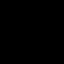

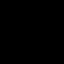

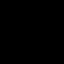

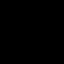

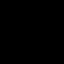

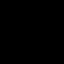

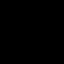

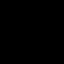

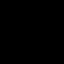

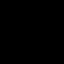

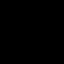

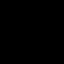

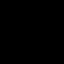

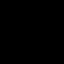

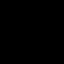

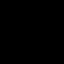

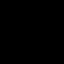

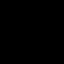

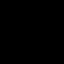

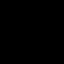

In [ ]:
#visualize saved train samples with mask
train_gifs = sorted(glob.glob("train_img*.gif"))
train_mask_gifs = sorted(glob.glob("train_mask*.gif"))

for i in range(len(train_gifs)):
  display(HTML(f"<h4>train image {i}</h4>"))
  display(Image(filename=train_gifs[i]))
  display(HTML(f"<h4>train mask {i}</h4>"))
  display(Image(filename=train_mask_gifs[i]))

In [ ]:
vit_3d_seg = SimpleViT3dSeg(
    image_size = 64,
    frames = 64,
    image_patch_size = 8,
    frame_patch_size = 8,
    num_classes = 3,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
)

1024 3


We train the model on 100 epochs without pre-training

In [ ]:
#training loop
epochs = 100
ce_loss = nn.CrossEntropyLoss()
vit_3d_seg.to(device)
optimizer = optim.Adam(vit_3d_seg.parameters(), lr=1e-3, weight_decay=1e-2)
train_loss_list, test_loss_list = [], []

best_test_loss = float('inf')
early_stop_patience = 25
early_stop_counter = 0
total_elapsed_time = 0

for ep in range(epochs):
  vit_3d_seg.train()
  train_loss = 0.0
  ep_start_time = time.perf_counter()

  for x, y in train_loader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits = vit_3d_seg(x)
    loss = ce_loss(logits, y)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  train_loss = train_loss / len(train_loader)

  #eval
  vit_3d_seg.eval()
  test_loss = 0.0
  with torch.no_grad():
    for x, y in test_loader:
      x, y = x.to(device), y.to(device)
      logits = vit_3d_seg(x)
      loss = ce_loss(logits, y)
      test_loss += loss.item()
    test_loss = test_loss / len(test_loader)

  if test_loss < best_test_loss:
    best_test_loss = test_loss
    early_stop_counter = 0

    #before saving the new best weight, del all old ones
    past_weights = glob.glob(f"{vit_3d_seg.__class__.__name__}_best*")
    for file in past_weights:
      os.remove(file)

    torch.save(vit_3d_seg.state_dict(), f"{vit_3d_seg.__class__.__name__}_best_{ep}ep.pth")
  else:
    early_stop_counter += 1
    if early_stop_counter >= early_stop_patience:
      print(f"Early stopping at epoch {ep}")
      break

  train_loss_list.append(train_loss)
  test_loss_list.append(test_loss)
  ep_end_time = time.perf_counter()
  ep_elapsed_time = ep_end_time - ep_start_time
  total_elapsed_time += ep_elapsed_time
  print(f"epoch: {ep}, train loss: {train_loss:.4f}, test loss: {test_loss:.4f}, elapsed time: {ep_elapsed_time:.4f}")


print(f"Total training time: {total_elapsed_time}")


#plot train val loss
plt.plot(train_loss_list, label='train loss')
plt.plot(test_loss_list, label='test loss')
plt.legend()
plt.show()
plt.title("Train and test cross entropy loss for model without skip connections")
plt.xlabel("Epoch")
plt.ylabel("CE Loss")

1024 3
epoch: 0, train loss: 0.5813, test loss: 9.1994, elapsed time: 16.9574
epoch: 1, train loss: 0.2990, test loss: 1.4371, elapsed time: 17.2325
epoch: 2, train loss: 0.2793, test loss: 1.1156, elapsed time: 16.9941
epoch: 3, train loss: 0.1985, test loss: 2.4269, elapsed time: 16.5623
epoch: 4, train loss: 0.1781, test loss: 1.7245, elapsed time: 16.5506
epoch: 5, train loss: 0.1609, test loss: 1.4957, elapsed time: 16.6367
epoch: 6, train loss: 0.1131, test loss: 2.0301, elapsed time: 16.7109
epoch: 7, train loss: 0.0679, test loss: 2.2406, elapsed time: 16.6932
epoch: 8, train loss: 0.0650, test loss: 2.2061, elapsed time: 16.6558
epoch: 9, train loss: 0.0362, test loss: 2.1281, elapsed time: 16.6507
epoch: 10, train loss: 0.0944, test loss: 0.6994, elapsed time: 16.9499
epoch: 11, train loss: 0.0638, test loss: 0.1548, elapsed time: 16.8651
epoch: 12, train loss: 0.0436, test loss: 0.3218, elapsed time: 16.5528
epoch: 13, train loss: 0.0278, test loss: 1.7091, elapsed time: 16.

In [ ]:
#dice score, source code from https://medium.com/data-scientists-diary/implementation-of-dice-loss-vision-pytorch-7eef1e438f68
def dice_loss(pred, target, smooth=1):
    """
    Computes the Dice Loss for binary segmentation.
    Args:
        pred: Tensor of predictions (batch_size, 1, H, W).
        target: Tensor of ground truth (batch_size, 1, H, W).
        smooth: Smoothing factor to avoid division by zero.
    Returns:
        Scalar Dice Loss.
    """
    # Apply sigmoid to convert logits to probabilities
    pred = torch.sigmoid(pred)

    # Calculate intersection and union
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))

    # Compute Dice Coefficient
    dice = (2. * intersection + smooth) / (union + smooth)

    # Return Dice Loss
    return 1 - dice.mean()

In [ ]:
#visualize some predictions
dice_score_list = {}

weight_path = glob.glob(f"{vit_3d_seg.__class__.__name__}_best*")[0]
print(f"using weight: {os.path.basename(weight_path)}")
vit_3d_seg.load_state_dict(torch.load("/content/SimpleViT3dSeg_best_42ep.pth"))
vit_3d_seg.to(device)
vit_3d_seg.eval()

for i in range(len(test_img)):
  img, mask = test_img[i], test_mask[i]
  img = img.unsqueeze(0).to(device)
  mask = mask.unsqueeze(0).to(device)
  logits = vit_3d_seg(img)
  pred_mask = vit_3d_seg.logits_to_mask(logits)
  pred_mask, mask = pred_mask.squeeze(0), mask.squeeze(0)

  pred_mask_name = f"pred_mask{i}.gif"
  save_gif(pred_mask, pred_mask_name)
  save_gif(mask, f"gt_mask{i}.gif")

  dice_score_list[pred_mask_name] = dice_loss(logits, mask.unsqueeze(0)).item()

using weight: SimpleViT3dSeg_best_42ep.pth


/tmp/ipython-input-237160731.py:92: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  frames.append(PILImage.fromarray(rgb[i], mode="RGB")) # Use PILImage alias


###Results visualization and Discussion

Here the model's prediction and ground truth, visualized. Overall, it seems like the model is capable of capturing the general location of the cube and sphere. However, the segmentation of the sphere is quite noisy compared to the grouth truth. However, Im not sure if this is due to limitation with using the ViT as an encoder or the simple architecture of the decoder.

The dice score is a bit low ranging from 0.5-0.7 especially considering the segmentation targets are simple objects. In the future, we could try adding skip connections to see if segmentation results improve.

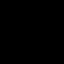

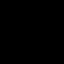

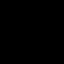

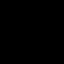

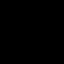

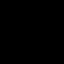

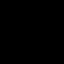

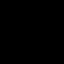

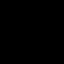

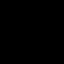

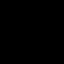

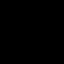

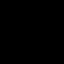

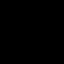

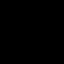

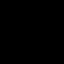

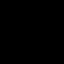

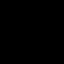

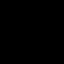

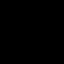

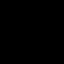

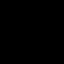

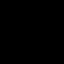

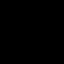

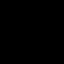

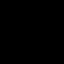

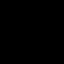

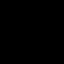

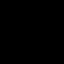

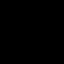

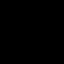

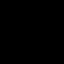

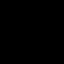

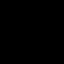

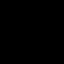

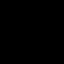

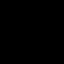

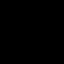

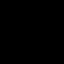

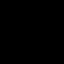

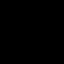

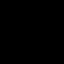

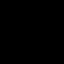

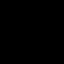

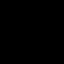

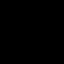

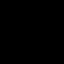

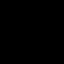

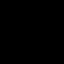

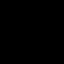

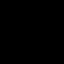

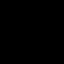

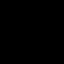

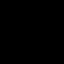

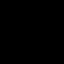

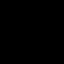

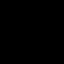

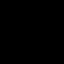

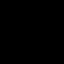

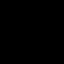

In [ ]:
#displaying test set predictions
pred_gifs = sorted(glob.glob("pred_mask*.gif"))
gt_gifs = sorted(glob.glob("gt_mask*.gif"))

for i in range(len(pred_gifs)):
  display(HTML(f"<h4>Prediction {i} with dice score {dice_score_list[pred_gifs[i]] :.3f} </h4>"))
  display(Image(filename=pred_gifs[i]))
  display(HTML(f"<h4>GT {i}</h4>"))
  display(Image(filename=gt_gifs[i]))